In [1]:
import rawpy
import numpy as np
import pyexifinfo
import cv2
import colour
import imageio.v3 as imageio
from pathlib import Path
from IPython.display import Image, display

def show(img: np.ndarray):
    if issubclass(img.dtype.type, np.floating):
        img = np.clip(img, 0, 1)
        img = (img * 255).astype(np.uint8)
    elif issubclass(img.dtype.type, np.integer):
        pass
    else:
        raise ValueError(f"Unsupported image type: {img.dtype}")
    display(Image(imageio.imwrite('<bytes>', img, extension='.jpg')))

def xyz_to_srgb(x):
    # Матрица преобразования из XYZ D50 в linear sRGB
    mat = colour.models.RGB_COLOURSPACES['sRGB'].matrix_XYZ_to_RGB @ np.array([
        [ 0.9555766, -0.0230393,  0.0631636],
        [-0.0282895,  1.0099416,  0.0210077],
        [ 0.0122982, -0.0204830,  1.3299098]
    ])
    x = x @ mat.T
    x = np.clip(x, 0, 1)
    # Гамма-коррекция преобразует linear sRGB
    # в обычный (нелинейный) sRGB, используемый мониторами
    x = np.where(
        x <= 0.0031308,
        12.92 * x,
        1.055 * np.power(x, 1/2.2) - 0.055
    )
    return x

def render_std(path: Path | str):
    with rawpy.imread(str(path)) as raw:
        return raw.postprocess(use_camera_wb=True, no_auto_bright=True, user_flip=0)

def read_raw(path: Path | str):
    with rawpy.imread(str(path)) as raw:
        img = raw.raw_image_visible
        # Демозаикинг
        img = cv2.cvtColor(img, cv2.COLOR_BAYER_BG2RGB)
        # Вычитание темнового тока
        img = img - raw.black_level_per_channel[:3]
        # Нормировка на максимальное допустимое сенсором значение
        img = img / (np.float64(raw.white_level) - raw.black_level_per_channel[:3])
    # Уменьшение картинки - для ускорения вычислений и ваших экспериментов :)
    img = cv2.resize(img, None, fx=1/12, fy=1/12)
    return img


# Лабораторная работа 1. Color Constancy
Цель работы: реализовать этапы преобразования цвета внутри пайплайна обработки изображения и убедиться в необходимости каждого из них.

В данной работе мы будем читать сырые изображения в формате DNG и пытаться рендерить их, то есть приводить к цветовому пространству монитора (sRGB) для отображения на нём.

Помогут некоторые вспомогательные функции:
- `read_raw` — читает сырое изображение из .dng-файла и возвращает его в виде numpy-массива размера H×W×3. В каждом пикселе хранятся три числа &mdash; зарегистрированные значения трёх цветовых каналов в диапазоне от 0 до 1.
- `xyz_to_srgb` — преобразовывает цвета из пространства XYZ в sRGB. На вход можно подавать как картинку (массив размера H×W×3), так и список цветов (N×3).
- `show` — показывает изображение, переданное в виде numpy-массива.

## Задача 1. Разминка
В колориметрии и профессиональной фотографии широко используются таблицы эталонных цветов (колорчекеры). В данной работе мы будем использовать образец с 24 цветами.

<img src="https://grafipress.de/cdn/shop/products/PI-CALB507_CCC-MEGA_-CalibriteCCCMega-Main_700x700.jpg" width="300px">

Дана сырая фотография колорчекера при солнечном свете.

In [4]:
cc_daylight_path = 'data1/cc-daylight.dng'

Давайте убедимся, что недостаточно просто взять и вывести сырое изображение на экран.

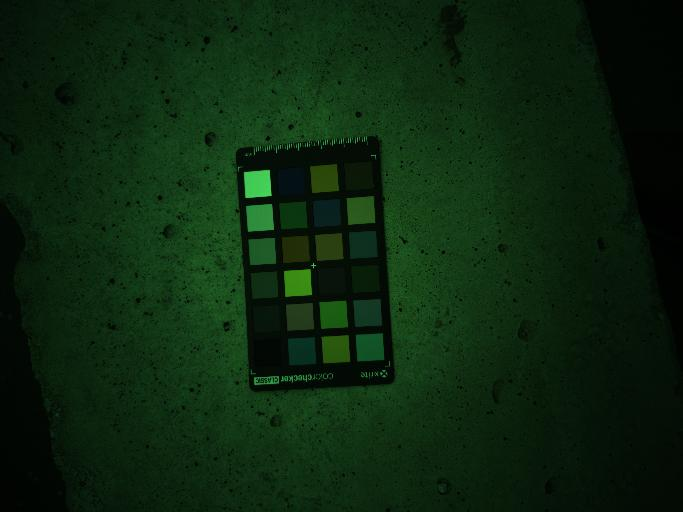

In [5]:
show(read_raw(cc_daylight_path))

Известно, что левый верхний угол колорчекера должен быть белым.
- Подберите диагональную матрицу линейного преобразования 3×3, которая приведёт его к значению [1, 1, 1].
- Примените эту матрицу к сырому изображению и проверьте результат визуально.

In [47]:
# Ваш код

- Какие цвета стали приемлемыми? Какие ещё далеки от идеала?

_Ваш ответ_

## Задача 2. Full matrix
Мы убедились, что преобразование из Camera RGB в sRGB не устроено тривиально. Однако мы ограничились только диагональными матрицами. Что, если снять это ограничение?

Давайте подберём матрицу 3×3, которая по максимуму приблизит все цвета колорчекера к их номинальным значениям. Иными словами, решим задачу оптимизации:

$$
\min_{T} \sum_{i=1}^{24} \| T \mathbf{a}_i - \mathbf{b}_i \|_2^2,
$$

где $\mathbf{a}_i \in \mathbb{R}^3$ — цвета колорчекера в Camera RGB, а $\mathbf{b}_i \in \mathbb{R}^3$ — номинальные цвета колорчекера.

Номинальные цвета колорчекера взяты из открытых источников, где они были даны в цветовом пространстве XYZ. Это стандартный способ передачи информации о цвете в науке. Однако подобранная таким образом матрица $A$ будет преобразовывать сырую фотографию не в sRGB, а в XYZ. Поэтому перед выводом на экран нужно будет преобразовать XYZ в sRGB при помощи функции`xyz_to_srgb`.

$\mathbf{b}_i$ даны в массиве `cc_xyz` размера 24×3, а $\mathbf{a}_i$ нужно взять из raw-фотографии. Но для этого нужно знать координаты 24 точек на фотографии. Мы подготовили их для вас в массиве `cc_coords` размера 24×2. Обратите внимание, что первая координата — это _y_, а вторая — _x_.

In [11]:
cc_xyz = np.array(list(colour.CCS_COLOURCHECKERS['ColorChecker 2005'].data.values()))
cc_xyz = colour.xyY_to_XYZ(cc_xyz)

cc_coords = np.array([[175, 359], [210, 360], [243, 363], [278, 365], [313, 368], [347, 370], [177, 324], [212, 327], [246, 329], [280, 331], [315, 334], [349, 335], [181, 291], [215, 293], [248, 296], [282, 298], [316, 300], [351, 302], [184, 258], [217, 260], [252, 262], [286, 264], [318, 266], [353, 267]])

- Напишите код, который по фотографии колорчекера из `cc_daylight_path`, координатам центров цветов в ней `cc_coords` и номинальным цветам колорчекера `cc_xyz` найдёт матрицу $T$ преобразования из Camera RGB в XYZ.
- Примените эту матрицу к сырому изображению и убедитесь, что все цвета близки к идеалу.

In [ ]:
# Ваш код

Теперь возьмём другую фотографию. Это тот же колорчекер, но снятый в помещении при свете лампы.

In [13]:
cc_lamp_path = 'data1/cc-lamp.dng'

- Не меняя матрицу $T$, примените её к этой фотографии.

In [66]:
# Ваш код

- В чём глобальный недостаток полученного изображения? Сравните с фотографиями, которые у вас обычно получаются под светом лампы. Почему так вышло?

_Ваш ответ_

- Возможно, на фотографии присутствуют пурпурные артефакты. Не обязательно исправлять их, но объясните, почему они возникли.

_Ваш ответ_

## Задача 3. Grey World

Мы убедились, что универсального преобразования из Camera RGB в XYZ не существует. Значит, оно должно адаптироваться к конкретным условиям съёмки. При этом понятно, что ставить колорчекер в каждую сцену довольно трудоёмко.

В современных камерах принят подход, при котором особое внимание уделяется белому цвету. Попробуем сделать так, чтобы наша матрица $T$ всегда хорошо справлялась с белым цветом. Допустим, нам с небес спустили $\mathbf{w}$ &mdash; цветовой отклик белой поверхности при съёмке в тех же условиях, что и фотография для обработки. Поделим цветовые отклики всех пикселей на $\mathbf{w}$ покомпонентно:

$$
\tilde{\mathbf{a}}_i := \frac{\mathbf{a}_i}{\mathbf{w}},
$$

и будем подберём матрицу $\tilde{T}$ на основе них:

$$
\min_{\tilde{T}} \sum_{i=1}^{24} \| \tilde{T} \tilde{\mathbf{a}}_i - \mathbf{b}_i \|_2^2.
$$

Теперь преобразование $\tilde{T}$ на любых фотографиях будет гарантированно хорошо работать с оттенками серого, если отклики в фотографии поделены на $\mathbf{w}$, подходящее конкретно для неё. Иными словами,

1. Преобразование $\tilde{T}$ универсально.
2. Калибровка $\mathbf{w}$ каждый раз своя.

Вопрос лишь в том, откуда взять $\mathbf{w}$ в момент съёмки.

Попробуем использовать предположение Grey World: средний цвет на фотографии должен быть серым. Тогда $\mathbf{w}$ можно будет найти как удвоенное среднее значение по всем пикселям:

$$
\mathbf{w} = \frac{2}{HW} \sum_{i=1}^{H} \sum_{j=1}^{W} \mathbf{p}_{ij},
$$

где $\mathbf{p}_{ij}$ — цветовой отклик пикселя с координатами $(i, j)$.

- В рамках предположения GreyWorld подберите матрицу $\tilde{T}$ для фотографии `cc_daylight_path` и обработайте ею фотографию `cc_lamp_path`.

In [ ]:
# Ваш код

- Какие проблемы исчезли? Какие появились?

_Ваш ответ_

## Задача 4. EXIF-tags

В реальных камерах $\textbf{w}$ вычисляется более хитрым образом и записывается в метаданные .dng-файла. Стандарт хранения этих данных называется EXIF. Для доступа к ним можно использовать библиотеку `pyexifinfo`.

- Выведите все EXIF-метки для фотографии `cc_daylight_path`.


In [22]:
# Ваш код

- Найдите в EXIF-метках искомую информацию о цвете белой поверхности. Используйте её в качестве $\mathbf{w}$ при фитировании матрицы $\tilde{T}$. Затем обработайте фотографию `cc_lamp_path`, используя $\mathbf{w}$ из _её_ EXIF-метки.


In [27]:
# Ваш код

- Сравните результаты в задачах 3 и 4. Сделайте выводы.
- Протестируйте пайплайны из задач 2, 3 и 4 на фотографии улицы `street_path`. Должно получиться три версии фотографии.

In [46]:
street_path = 'data1/street.dng'
# Ваш код

- В каких пайплайных компенсация освещения удалась, а в каких нет?
- Могут ли быть ситуации, когда полностью компенсировать эффект освещения не нужно?

_Ваш ответ_